<a href="https://colab.research.google.com/github/Sarang19114/Bone-Fracture-Classification/blob/main/FractureDetecter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

In [ ]:
import keras
import tensorflow.python.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
# from keras.backend import set_session
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Conv2D, Dense, Flatten, MaxPool2D
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.compat.v1 import ConfigProto
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras import layers
print(tf.__version__)

2.18.0


In [ ]:
from sklearn.metrics import f1_score, recall_score

def print_scores(y_true, y_pred):
    f1 = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    print("F1 Score:", f1)
    print("Recall:", recall)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# PRESS cuDNN, cuFFT, and cuBLAS ERRORS
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# DATAPATH
train_fractured_image_dir = r"/content/drive/MyDrive/Bone_Fracture_Binary_Classification/train/fractured"
train_nonfractured_image_dir = r"/content/drive/MyDrive/Bone_Fracture_Binary_Classification/train/notfractured"
test_fractured_image_dir = r"/content/drive/MyDrive/Bone_Fracture_Binary_Classification/test/fractured"
test_nonfractured_image_dir = r"/content/drive/MyDrive/Bone_Fracture_Binary_Classification/test/notfractured"
val_fractured_image_dir = r"/content/drive/MyDrive/Bone_Fracture_Binary_Classification/val/fractured"
val_nonfractured_image_dir = r"/content/drive/MyDrive/Bone_Fracture_Binary_Classification/val/notfractured"

# FUNCTION TO PREPROCESS AND LOAD AN IMAGE
def preprocess_image(image_path, target_size=(128, 128)):
    try:
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, target_size)
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
        image = tf.image.random_saturation(image, lower=0.2, upper=1.8)
        image = tf.image.random_hue(image, max_delta=0.1)
        image = tf.clip_by_value(image, 0, 255)
        image = image / 255.0
        return image
    except Exception as e:
        print(f"Error processing image: {image_path}, {e}")
        return None

# FUNCTION TO LOAD AND PREPROCESS IMAGES FROM A DIRECTORY
def load_and_preprocess_images(image_dir):
    images = []
    image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir)]
    for image_path in image_paths:
        image = preprocess_image(image_path)
        if image is not None:
            images.append(image)
    return images

# LOAD AND PREPROCESS TRAIN FRACTURED IMAGES
train_fractured_images = load_and_preprocess_images(train_fractured_image_dir)
train_fractured_labels = np.zeros(len(train_fractured_images))  # Set label 0 for fractured images

# LOAD AND PREPROCESS TRAIN NONFRACTURED IMAGES
train_nonfractured_images = load_and_preprocess_images(train_nonfractured_image_dir)
train_nonfractured_labels = np.ones(len(train_nonfractured_images))  # Set label 1 for nonfractured images

# COMBINE TRAIN FRACTURED AND NONFRACTURED IMAGES
images = train_fractured_images + train_nonfractured_images
labels = np.concatenate([train_fractured_labels, train_nonfractured_labels])

# ENCODE LABELS
encoder = OneHotEncoder(sparse_output=False)
labels = encoder.fit_transform(labels.reshape(-1, 1))

# CONVERT IMAGES AND LABELS TO NUMPY ARRAYS
images = np.array(images)
labels = np.array(labels)

# SHUFFLE IMAGES AND LABELS
indices = np.arange(len(images))
np.random.shuffle(indices)
images = images[indices]
labels = labels[indices]

# CREATE TENSORFLOW DATASET
dataset = tf.data.Dataset.from_tensor_slices((images, labels))

BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE  # Optimizes data loading

# SPLIT DATA SET INTO TRAIN AND TEST
train_size = int(0.8 * len(images))
test_size = len(images) - train_size

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

# Batch, shuffle, and prefetch for better performance
train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# CHECK SHAPE
print("Train dataset shape:", train_size)
print("Test dataset shape:", test_size)

Error processing image: /content/drive/MyDrive/Bone_Fracture_Binary_Classification/train/notfractured/IMG0004143.jpg, {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeJpeg]
Error processing image: /content/drive/MyDrive/Bone_Fracture_Binary_Classification/train/notfractured/IMG0004134.jpg, {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeJpeg]
Error processing image: /content/drive/MyDrive/Bone_Fracture_Binary_Classification/train/notfractured/IMG0004149.jpg, {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeJpeg]
Error processing image: /content/drive/MyDrive/Bone_Fracture_Binary_Classification/train/notfractured/IMG0004308.jpg, {{function_node __wrapped__

In [ ]:
import pandas as pd

# Create Train DataFrame
train_filepaths = [os.path.join(train_fractured_image_dir, filename) for filename in os.listdir(train_fractured_image_dir)] + \
                  [os.path.join(train_nonfractured_image_dir, filename) for filename in os.listdir(train_nonfractured_image_dir)]
train_labels = ["Fractured"] * len(os.listdir(train_fractured_image_dir)) + \
               ["Not Fractured"] * len(os.listdir(train_nonfractured_image_dir))
train_df = pd.DataFrame({"Filepath": train_filepaths, "Label": train_labels})

# Create Validation DataFrame
val_filepaths = [os.path.join(val_fractured_image_dir, filename) for filename in os.listdir(val_fractured_image_dir)] + \
                [os.path.join(val_nonfractured_image_dir, filename) for filename in os.listdir(val_nonfractured_image_dir)]
val_labels = ["Fractured"] * len(os.listdir(val_fractured_image_dir)) + \
             ["Not Fractured"] * len(os.listdir(val_nonfractured_image_dir))
val_df = pd.DataFrame({"Filepath": val_filepaths, "Label": val_labels})

# Create Test DataFrame
test_filepaths = [os.path.join(test_fractured_image_dir, filename) for filename in os.listdir(test_fractured_image_dir)] + \
                 [os.path.join(test_nonfractured_image_dir, filename) for filename in os.listdir(test_nonfractured_image_dir)]
test_labels = ["Fractured"] * len(os.listdir(test_fractured_image_dir)) + \
              ["Not Fractured"] * len(os.listdir(test_nonfractured_image_dir))
test_df = pd.DataFrame({"Filepath": test_filepaths, "Label": test_labels})

# Display first few rows
print(train_df.head())  # Check Train DataFrame
print(val_df.head())    # Check Validation DataFrame
print(test_df.head())   # Check Test DataFrame

                                            Filepath      Label
0  /content/drive/MyDrive/Bone_Fracture_Binary_Cl...  Fractured
1  /content/drive/MyDrive/Bone_Fracture_Binary_Cl...  Fractured
2  /content/drive/MyDrive/Bone_Fracture_Binary_Cl...  Fractured
3  /content/drive/MyDrive/Bone_Fracture_Binary_Cl...  Fractured
4  /content/drive/MyDrive/Bone_Fracture_Binary_Cl...  Fractured
                                            Filepath      Label
0  /content/drive/MyDrive/Bone_Fracture_Binary_Cl...  Fractured
1  /content/drive/MyDrive/Bone_Fracture_Binary_Cl...  Fractured
2  /content/drive/MyDrive/Bone_Fracture_Binary_Cl...  Fractured
3  /content/drive/MyDrive/Bone_Fracture_Binary_Cl...  Fractured
4  /content/drive/MyDrive/Bone_Fracture_Binary_Cl...  Fractured
                                            Filepath      Label
0  /content/drive/MyDrive/Bone_Fracture_Binary_Cl...  Fractured
1  /content/drive/MyDrive/Bone_Fracture_Binary_Cl...  Fractured
2  /content/drive/MyDrive/Bone_Fracture_

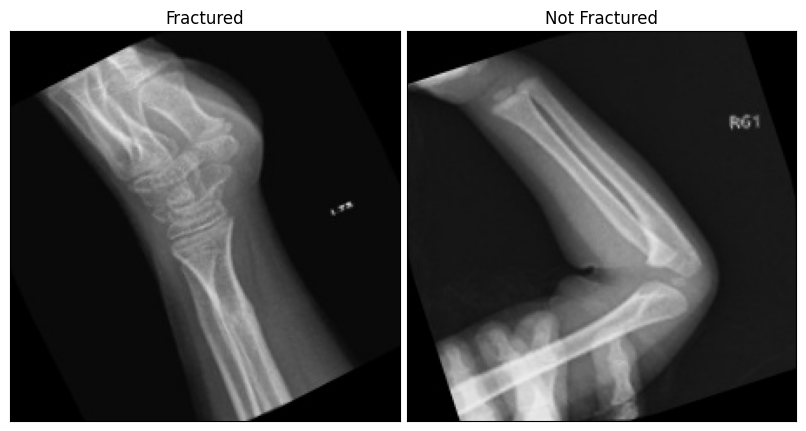

In [ ]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
model = tf.keras.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPool2D(pool_size=2, strides=2),
    layers.Conv2D(128, (3, 3), activation='relu', input_shape=(128, 128, 3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(128, (3, 3), activation='relu', input_shape=(128, 128, 3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPool2D(pool_size=2, strides=2),
    layers.Conv2D(256, (3, 3), activation='relu', input_shape=(128, 128, 3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(256, (3, 3), activation='relu', input_shape=(128, 128, 3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(256, (3, 3), activation='relu', input_shape=(128, 128, 3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(256, (3, 3), activation='relu', input_shape=(128, 128, 3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPool2D(pool_size=2, strides=2),
    layers.Conv2D(512, (3, 3), activation='relu', input_shape=(128, 128, 3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(512, (3, 3), activation='relu', input_shape=(128, 128, 3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPool2D(pool_size=2, strides=2),
    layers.Conv2D(512, (3, 3), activation='relu', input_shape=(128, 128, 3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(512, (3, 3), activation='relu', input_shape=(128, 128, 3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPool2D(pool_size=2, strides=2),
    layers.Conv2D(512, (3, 3), activation='relu', input_shape=(128, 128, 3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(512, (3, 3), activation='relu', input_shape=(128, 128, 3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPool2D(pool_size=2, strides=2),
    layers.Conv2D(512, (3, 3), activation='relu', input_shape=(128, 128, 3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(512, (3, 3), activation='relu', input_shape=(128, 128, 3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPool2D(pool_size=2, strides=2),

    layers.AveragePooling2D(pool_size=1, strides=1),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy,
                  metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32, 32, 256)         │           1,0

 Total params: 20,047,426 (76.47 MB)

 Trainable params: 20,036,418 (76.43 MB)

 Non-trainable params: 11,008 (43.00 KB)

In [ ]:
history = model.fit(
    train_dataset,  # ✅ No need to batch again
    epochs=20,
    validation_data=test_dataset,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=7,
            restore_best_weights=True,
            mode='max'
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath='/content/drive/MyDrive/boneFracturedModel.keras',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        )
    ]
)


Epoch 1/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 48s 208ms/step - accuracy: 0.8092 - loss: 0.4181 - val_accuracy: 0.7614 - val_loss: 0.4791
Epoch 2/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 49s 212ms/step - accuracy: 0.8312 - loss: 0.3847 - val_accuracy: 0.7906 - val_loss: 0.4479
Epoch 3/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 82s 212ms/step - accuracy: 0.8618 - loss: 0.3264 - val_accuracy: 0.8225 - val_loss: 0.4415
Epoch 4/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 50s 216ms/step - accuracy: 0.9008 - loss: 0.2514 - val_accuracy: 0.8323 - val_loss: 0.4121
Epoch 5/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 81s 212ms/step - accuracy: 0.9113 - loss: 0.2226 - val_accuracy: 0.8501 - val_loss: 0.3746
Epoch 6/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 56s 241ms/step - accuracy: 0.9270 - loss: 0.1900 - val_accuracy: 0.8696 - val_loss: 0.2821
Epoch 7/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 55s 238ms/step - accuracy: 0.9367 - loss: 0.1655 - val_accuracy: 0.8934 - val_loss: 0.2698
Epoch 8/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 80s 230ms/step - accuracy: 0.9379 - loss: 0

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9418 - loss: 0.1662
Test Loss: 0.15309874713420868
Test Accuracy: 0.9448052048683167


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


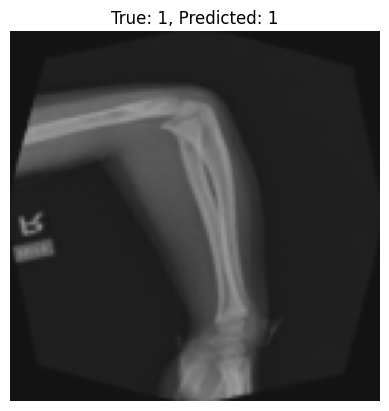

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


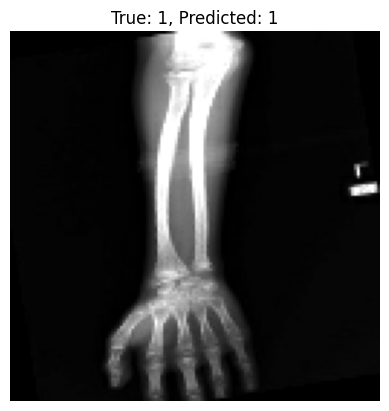

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


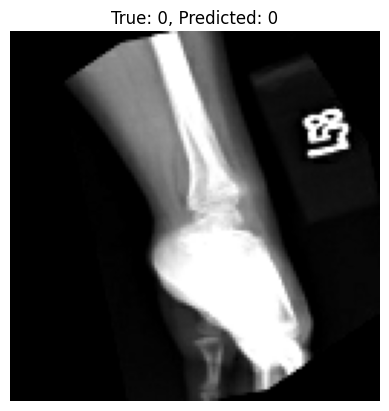

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


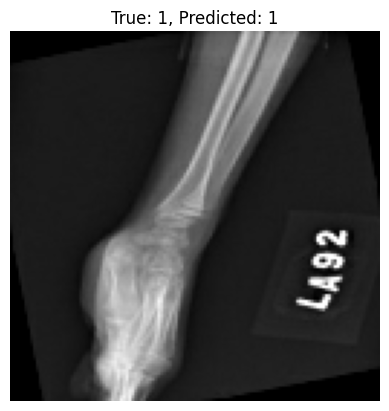

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


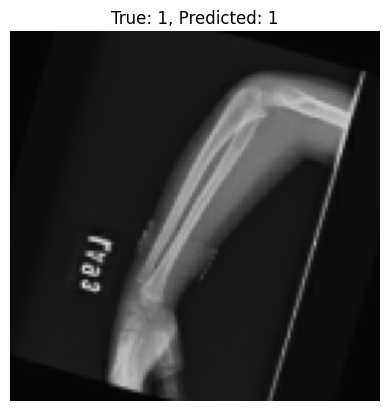

In [ ]:
num_images_to_print = 5

for batch_images, batch_labels in test_dataset.take(1):  # Take one batch
    for i in range(num_images_to_print):  # Loop through images in batch
        image = batch_images[i]  # Extract single image
        label = batch_labels[i]  # Extract corresponding label

        prediction = model.predict(tf.expand_dims(image, axis=0))  # Expand dims to match model input shape
        predicted_label = np.argmax(prediction)

        plt.imshow(image.numpy())  # Convert tensor to numpy before plotting
        plt.title(f'True: {np.argmax(label)}, Predicted: {predicted_label}')
        plt.axis('off')
        plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import f1_score, recall_score

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test dataset and make predictions
for image_batch, label_batch in test_dataset:
    # Make predictions for the batch
    predictions = model.predict(image_batch)  # No need for tf.expand_dims()

    # Convert predictions to class indices
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(np.argmax(label_batch.numpy(), axis=1))

# Convert lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Compute F1 score and recall
f1 = f1_score(true_labels, predicted_labels, average='weighted')  # Use 'macro' or 'weighted' for multi-class
recall = recall_score(true_labels, predicted_labels, average='weighted')

print("F1 Score:", f1)
print("Recall:", recall)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81

In [ ]:
import numpy as np
import cv2  # OpenCV for image processing
import matplotlib.pyplot as plt
from tensorflow import keras
from google.colab import drive

# Step 2: Load the Trained Model (.keras format)
model_path = "/content/drive/MyDrive/boneFracturedModel.keras"  # Update the path
model = keras.models.load_model(model_path)

print("Model loaded successfully!")

# Step 3: Load and Preprocess the Image
image_path = "/content/drive/MyDrive/Bone_Fracture_Binary_Classification/newdata/image.png"  # Update the path

# Read the image
image = cv2.imread(image_path)
if image is None:
    print("Error: Image not found. Check the file path.")
else:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image = cv2.resize(image, (128, 128))  # Resize to match model's expected input size
    image = image / 255.0  # Normalize pixel values to [0,1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Step 4: Get the Model's Prediction
    prediction = model.predict(image)

    # Step 5: Display Image with Prediction
    plt.imshow(image[0])  # Remove batch dimension for visualization
    plt.title(f"Predicted Label: {predicted_label}")
    plt.axis("off")
    plt.show()


ValueError: File not found: filepath=/content/drive/MyDrive/boneFracturedModel.keras. Please ensure the file is an accessible `.keras` zip file.